In [1]:
#!git clone https://github.com/anupamhap/mb.git
!git clone https://github.com/shreyasrivastava17/melbournewater.git

Cloning into 'melbournewater'...
remote: Counting objects: 184, done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 184 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (184/184), 9.43 MiB | 54.27 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [0]:
!pwd

In [3]:
import os
os.chdir("melbournewater")


In [4]:
!ls

data  Debris Detection	README.md


In [5]:
import csv
import matplotlib.image as mpimg
import cv2
import numpy as np
import os
import logging
import glob

In [6]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Activation, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from sklearn.model_selection import train_test_split
import sklearn

Using TensorFlow backend.


In [7]:
width = 58
height = 58

images = []

In [12]:
roots   = glob.glob('data/debris/*.PNG')
non_roots   = glob.glob('data/non-debris/*.PNG')
# non_roots   += glob.glob('data/non_tree/*.jpg')
print(len(roots), len(non_roots))
img=cv2.imread(roots[0])
print(img.shape)

46 55
(199, 202, 3)


In [10]:
img_size=64
def show3img(img, img1, img2):
   plt.figure(figsize=(6, 2))
   plt.subplot(1, 3, 1)
   plt.imshow(img)
   plt.title("Raw image")
   plt.subplot(1, 3, 2)
   plt.imshow(img1)
   plt.title("Processed image")
   plt.subplot(1, 3, 3)
   plt.imshow(img2)
   plt.title("Augmented image")
   plt.show()
   
def eq_Hist(img):
   #Histogram Equalization
   img2=img.copy()
   img2[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
   img2[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
   img2[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
   return img2

def scale_img(img):
   img2=img.copy()
   sc_y=0.4*np.random.rand()+1.0
   img2=cv2.resize(img, None, fx=1, fy=sc_y, interpolation = cv2.INTER_CUBIC)
   c_x,c_y, sh = int(img2.shape[0]/2), int(img2.shape[1]/2), int(img_size/2)
   return img2

def crop(img, mar=0):
   c_x,c_y, sh = int(img.shape[0]/2), int(img.shape[1]/2), int(img_size/2-mar)
   return img[(c_x-sh):(c_x+sh),(c_y-sh):(c_y+sh)]

def rotate_img(img):
   c_x,c_y = int(img.shape[0]/2), int(img.shape[1]/2)
   ang = 30.0*np.random.rand()-15
   Mat = cv2.getRotationMatrix2D((c_x, c_y), ang, 1.0)
   return cv2.warpAffine(img, Mat, img.shape[:2])

def sharpen_img(img):
   gb = cv2.GaussianBlur(img, (5,5), 20.0)
   return cv2.addWeighted(img, 2, gb, -1, 0)
#Compute linear image transformation ing*s+m
def lin_img(img,s=1.0,m=0.0):
   img2=cv2.multiply(img, np.array([s]))
   return cv2.add(img2, np.array([m]))

#Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
   m=127.0*(1.0-s)
   return lin_img(img, s, m)

def transform_img(img):
   img2=sharpen_img(img)
   img2=crop(img2,3)
   img2=contr_img(img2, 1.5)
   return eq_Hist(img2)

def augment_img(img):
   img=contr_img(img, 1.8*np.random.rand()+0.2)
   img=rotate_img(img)
   img=scale_img(img)
   return transform_img(img)


In [26]:
X_train_aug_roots = []
y_train_aug = []

def create_data(n=10):
   for i in range(len(roots)):
       img=cv2.imread(roots[i])
       img=cv2.resize(img, (64, 64))
       X_train_aug_roots.append(transform_img(img))
       y_train_aug.append(1)
       #Generate n new images out of each input image
       for j in range(n):
           X_train_aug_roots.append(augment_img(img))
           y_train_aug.append(1)      
   print("Total number of images in the augmented dataset = ", len(X_train_aug_roots))

create_data(7)

Total number of images in the augmented dataset =  368


In [27]:
def create_data(n=10):
   for i in range(len(non_roots)):
       img=cv2.imread(non_roots[i])
       img=cv2.resize(img, (64, 64))
       X_train_aug_roots.append(transform_img(img))
       y_train_aug.append(0)
       #Generate n new images out of each input image
       for j in range(n):
           X_train_aug_roots.append(augment_img(img))
           y_train_aug.append(0)      
   print("Total number of images in the augmented dataset = ", len(X_train_aug_roots))

create_data(7)

Total number of images in the augmented dataset =  808


In [28]:
print(len(roots))
print(X_train_aug_roots[0].shape)

46
(58, 58, 3)


In [29]:
for i in range(len(roots)):
     img=cv2.imread(roots[i])
     img=cv2.resize(img, (58, 58))
     X_train_aug_roots.append(img)
     y_train_aug.append(1)

for i in range(len(non_roots)):
     img=cv2.imread(non_roots[i])
     img=cv2.resize(img, (58, 58))
     X_train_aug_roots.append(img)
     y_train_aug.append(0)
   
print(len(y_train_aug))

909


In [30]:
activation = 'relu'
dropout = 1

def model(dshape):
    
    seq_model = Sequential()

    seq_model.add(BatchNormalization(input_shape=(dshape[0], dshape[1], dshape[2])))
    seq_model.add(Conv2D(24, (5, 5), padding='valid',
                  activation=activation, strides=(2, 2)))

    seq_model.add(Conv2D(36, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.6))
    seq_model.add(Conv2D(48, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.6))
    seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Dropout(0.6))
#   seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Flatten())
    seq_model.add(Dropout(0.6))
    seq_model.add(Dense(100, activation=activation))
    seq_model.add(Dropout(0.5))
    seq_model.add(Dense(50, activation=activation))
    seq_model.add(Dropout(0.3))
    seq_model.add(Dense(10, activation=activation))
    seq_model.add(Dense(1, activation='sigmoid'))
    seq_model.compile(loss='binary_crossentropy', optimizer=adam(), metrics=['accuracy'])
    seq_model.summary()

    return seq_model

In [31]:
from sklearn.utils import shuffle
from keras.utils.data_utils import Sequence

images, labels = shuffle(X_train_aug_roots, y_train_aug)

In [32]:
for i in range(len(X_train_aug_roots)):
  if(X_train_aug_roots[i].shape[2]!=3):
    print(X_train_aug_roots[i].shape)

In [33]:
images = np.asarray(images)
labels = np.asarray(labels)
print(images.dtype, images.shape)
print(type(images))
print(labels)

uint8 (909, 58, 58, 3)
<class 'numpy.ndarray'>
[0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0
 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1
 0 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 0 1 0
 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1
 0 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 1
 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0
 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1
 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1
 1 1 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0
 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 1
 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 1
 0 1 1 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 1 0
 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import adam
#from keras.utils.data_utils import Sequence

keras_model = model((height, width, 3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 58, 58, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 36)        21636     
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 48)          43248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 48)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 64)          27712     
__________

In [35]:
keras_model.fit(images, labels, epochs=25, batch_size=32, verbose=1, shuffle=True, validation_split=0.2)

Train on 727 samples, validate on 182 samples
Epoch 1/25
727/727 [==============================] - 4s 5ms/step - loss: 0.7075 - acc: 0.5530 - val_loss: 0.6883 - val_acc: 0.5824
Epoch 2/25
727/727 [==============================] - 3s 4ms/step - loss: 0.6907 - acc: 0.5323 - val_loss: 0.6894 - val_acc: 0.6538
Epoch 3/25
727/727 [==============================] - 3s 4ms/step - loss: 0.6712 - acc: 0.5337 - val_loss: 0.6802 - val_acc: 0.6593
Epoch 4/25
727/727 [==============================] - 3s 4ms/step - loss: 0.6682 - acc: 0.5516 - val_loss: 0.6615 - val_acc: 0.6209
Epoch 5/25
727/727 [==============================] - 3s 4ms/step - loss: 0.6583 - acc: 0.5475 - val_loss: 0.6454 - val_acc: 0.6429
Epoch 6/25
727/727 [==============================] - 3s 4ms/step - loss: 0.6492 - acc: 0.5805 - val_loss: 0.6421 - val_acc: 0.6484
Epoch 7/25
727/727 [==============================] - 3s 4ms/step - loss: 0.6343 - acc: 0.5901 - val_loss: 0.6336 - val_acc: 0.6429
Epoch 8/25
416/727 [==========

727/727 [==============================] - 3s 4ms/step - loss: 0.6263 - acc: 0.6327 - val_loss: 0.6000 - val_acc: 0.6374
Epoch 9/25
727/727 [==============================] - 3s 4ms/step - loss: 0.6245 - acc: 0.6355 - val_loss: 0.6371 - val_acc: 0.6923
Epoch 10/25
727/727 [==============================] - 3s 4ms/step - loss: 0.6110 - acc: 0.6327 - val_loss: 0.5905 - val_acc: 0.6758
Epoch 11/25
727/727 [==============================] - 3s 4ms/step - loss: 0.6142 - acc: 0.6451 - val_loss: 0.6006 - val_acc: 0.6923
Epoch 12/25
727/727 [==============================] - 3s 4ms/step - loss: 0.5923 - acc: 0.6465 - val_loss: 0.5794 - val_acc: 0.6813
Epoch 13/25
727/727 [==============================] - 3s 4ms/step - loss: 0.6007 - acc: 0.6602 - val_loss: 0.5750 - val_acc: 0.7088
Epoch 14/25
727/727 [==============================] - 3s 4ms/step - loss: 0.6021 - acc: 0.6740 - val_loss: 0.5669 - val_acc: 0.7143
Epoch 15/25
727/727 [==============================] - 3s 4ms/step - loss: 0.5825 

Epoch 16/25
727/727 [==============================] - 3s 4ms/step - loss: 0.5784 - acc: 0.6960 - val_loss: 0.5717 - val_acc: 0.6484
Epoch 17/25
727/727 [==============================] - 3s 4ms/step - loss: 0.5926 - acc: 0.7001 - val_loss: 0.5509 - val_acc: 0.7527
Epoch 18/25
727/727 [==============================] - 3s 4ms/step - loss: 0.5756 - acc: 0.7070 - val_loss: 0.5788 - val_acc: 0.7363
Epoch 19/25
727/727 [==============================] - 3s 4ms/step - loss: 0.5446 - acc: 0.7373 - val_loss: 0.5439 - val_acc: 0.7418
Epoch 20/25
727/727 [==============================] - 3s 4ms/step - loss: 0.5529 - acc: 0.7359 - val_loss: 0.5253 - val_acc: 0.7582
Epoch 21/25
727/727 [==============================] - 3s 4ms/step - loss: 0.5238 - acc: 0.7758 - val_loss: 0.5005 - val_acc: 0.7912
Epoch 22/25
727/727 [==============================] - 3s 4ms/step - loss: 0.5196 - acc: 0.7565 - val_loss: 0.4781 - val_acc: 0.7912
Epoch 23/25
640/727 [=========================>....] - ETA: 0s - loss

727/727 [==============================] - 3s 4ms/step - loss: 0.4647 - acc: 0.7882 - val_loss: 0.4640 - val_acc: 0.8242
Epoch 24/25
727/727 [==============================] - 3s 4ms/step - loss: 0.4658 - acc: 0.8294 - val_loss: 0.4638 - val_acc: 0.8022
Epoch 25/25
727/727 [==============================] - 3s 4ms/step - loss: 0.4316 - acc: 0.8294 - val_loss: 0.4861 - val_acc: 0.7857


In [36]:
def  save_keras_model (save_model, path):
    """Save keras model to given path."""
    save_model.save_weights(path + 'model.h5')

    with open(path + 'model.json', "w") as text_file:
        text_file.write(save_model.to_json())

    logging.info('Keras json model saved. %s', path + 'model.json')
    logging.info('Keras h5 model saved. %s', path + 'model.h5')

In [37]:
save_keras_model(keras_model, 'keras')

In [38]:
!ls

data  Debris Detection	kerasmodel.h5  kerasmodel.json	README.md


# New Section

In [39]:
from google.colab import files


files.download('kerasmodel.h5')
files.download('kerasmodel.json')


In [40]:
from keras.models import model_from_json
model_path = 'kerasmodel'

inf_model = model_from_json(open(model_path + '.json','r').read())
inf_model.load_weights(model_path + '.h5')

In [41]:
def find_roots(img, ystart, ystop, scale, pix_per_cell,cell_per_block):#, svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins):
    
    boxes=[]
  
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
#     ctrans_tosearch = hp.convert_color(img_tosearch, conv=color_space)
    ctrans_tosearch = img_tosearch
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
#     nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    print(nxsteps)
    
#     # Compute individual channel HOG features for the entire image
#     hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
#             hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
           
#             hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (58,58))
#             plt.imshow(subimg)
#             plt.show
            # Get color features
#             spatial_features = hp.bin_spatial(subimg, size=spatial_size)
#             hist_features = hp.color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
#             test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))  
            test_prediction = round(inf_model.predict(np.expand_dims(subimg, 0))[0, 0])
#             print(test_prediction)
#             test_prediction = svc.predict(test_features)
            
            if test_prediction == 1.0:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))#,(0,0,255),6)) 
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return boxes

In [42]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    for box in bboxes:
        cv2.rectangle(draw_img,box[0],box[1],color,thick)
    
    return draw_img # Change this line to return image copy with boxes

['test/test1.PNG', 'test/test4.PNG', 'test/test2.PNG', 'test/test3.PNG']
test/test1.PNG
6


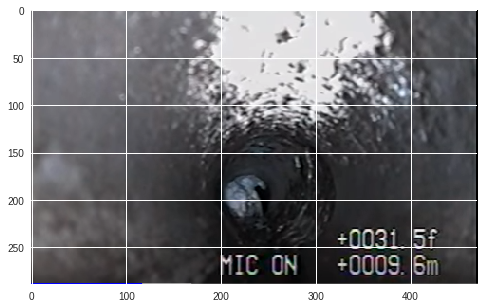

test/test4.PNG
10


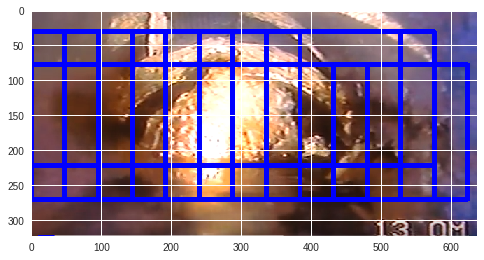

test/test2.PNG
6


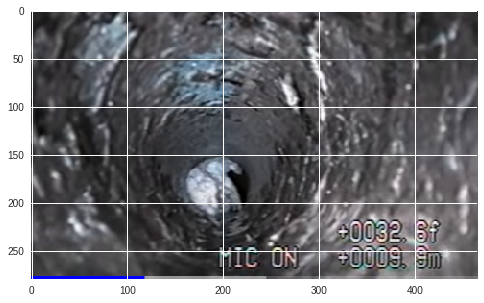

test/test3.PNG
6


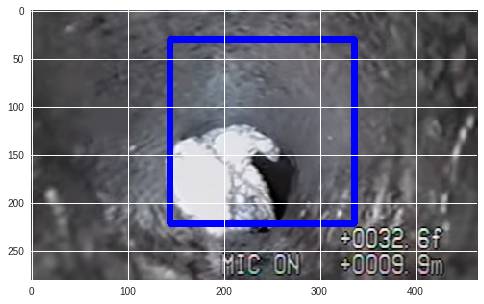

In [72]:
import matplotlib.pyplot as plt
ystart = 30
ystop = 270
scale = 3
pix_per_cell=8
cell_per_block=2
test_images=glob.glob('test/*.PNG')
print(test_images)
for fname in test_images:
    print(fname)
    test_img=cv2.imread(fname)
    plt.imshow(test_img)
    #plt.subplot(6,1,i)
    boxes=find_roots(test_img, ystart, ystop, scale, pix_per_cell,cell_per_block ) #, clf, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins)
    #print(boxes[0][0])
    test_out_img=draw_boxes(test_img,boxes)
    plt.imshow(test_out_img)
    plt.show()

In [71]:
os.chdir("..")
# !git pull origin melbournewater
!ls
# git pull origin experiment
# !git clone https://github.com/shreyasrivastava17/test.git

datalab  melbournewater  test


(289, 471, 3)


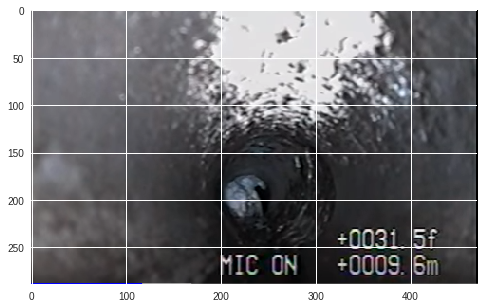

In [70]:
import matplotlib.pyplot as plt
img = cv2.imread("test1.PNG")
print(img.shape)
plt.imshow(img)
# cv2.imshow('image',img)

In [62]:
os.chdir("test")
!ls

README.md  test1.PNG  test2.PNG  test3.PNG  test4.PNG


In [0]:
im = mpimg.imread( "data/non_tree/1.JPG")
im = cv2.resize(im,(58,58))
print( round(inf_model.predict(np.expand_dims(im, 0))[0, 0]))

In [0]:
!ls

test_image1.png  treeroot.JPG


In [0]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [0]:
#print(scales,ystarts)
from collections import deque

heat_history=deque(maxlen=8)
def process_frame(image):
    boxes=[]
#     for i in range(len(scales)):
    boxes.append(find_roots(image, ystart, ystop, scale, pix_per_cell,cell_per_block )) #find_roots(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins))
    
    boxes = [item for sublist in boxes for item in sublist] 
    heatmap_img = np.zeros_like(image[:,:,0])
    heatmap_img = add_heat(heatmap_img, boxes)
    
#     heat_history.append(heatmap_img)
#     heatmap_img = np.array(heat_history).sum(axis=0)
    heatmap_img = apply_threshold(heatmap_img,2)
    
    # # Find final boxes from heatmap using label function
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
#     draw_img = draw_boxes(image,boxes)
    
    return draw_img


In [0]:
os.chdir("Tree_Root_Detection")

In [0]:
from moviepy.editor import VideoFileClip

output_location = 'sewer_footage1_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
video_input = VideoFileClip("sewer_footage1")#.subclip(8,10)

video_output = video_input.fl_image(process_frame) #NOTE: this function expects color images!!

#%time undist_clip.write_videofile(undist_output, audio=False)
# print("anupam")
video_output.write_videofile(output_location, audio=False)
video_input.reader.close()
video_input.audio.reader.close_proc()
video_output.reader.close()
video_output.audio.reader.close_proc()

7
[MoviePy] >>>> Building video sewer_footage1_output.mp4
[MoviePy] Writing video sewer_footage1_output.mp4


  0%|          | 3/2977 [00:00<02:04, 23.86it/s]

7
7
7
7
7


  0%|          | 8/2977 [00:00<02:14, 22.12it/s]

7
7
7
7
7


  0%|          | 11/2977 [00:00<02:13, 22.22it/s]

7
7
7
7


  0%|          | 14/2977 [00:00<02:12, 22.40it/s]

7


  1%|          | 17/2977 [00:00<02:11, 22.42it/s]

7
7
7
7


  1%|          | 19/2977 [00:00<02:13, 22.10it/s]

7


  1%|          | 22/2977 [00:00<02:13, 22.13it/s]

7
7
7
7
7


  1%|          | 28/2977 [00:01<02:11, 22.40it/s]

7
7
7
7
7


  1%|          | 31/2977 [00:01<02:11, 22.34it/s]

7
7
7
7


  1%|          | 34/2977 [00:01<02:11, 22.41it/s]

7


  1%|          | 37/2977 [00:01<02:10, 22.48it/s]

7
7
7
7
7


  1%|▏         | 43/2977 [00:01<02:11, 22.31it/s]

7
7
7
7


  2%|▏         | 46/2977 [00:02<02:12, 22.16it/s]

7
7
7
7
7


  2%|▏         | 52/2977 [00:02<02:12, 22.01it/s]

7
7
7
7
7


  2%|▏         | 55/2977 [00:02<02:12, 21.99it/s]

7
7
7
7


  2%|▏         | 58/2977 [00:02<02:12, 21.97it/s]

7


  2%|▏         | 61/2977 [00:02<02:12, 21.96it/s]

7
7
7
7
7


  2%|▏         | 67/2977 [00:03<02:12, 21.93it/s]

7
7
7
7
7


  2%|▏         | 70/2977 [00:03<02:13, 21.80it/s]

7
7
7
7


  2%|▏         | 73/2977 [00:03<02:13, 21.75it/s]

7


  3%|▎         | 76/2977 [00:03<02:13, 21.80it/s]

7
7
7
7
7


  3%|▎         | 82/2977 [00:03<02:13, 21.75it/s]

7
7
7
7
7


  3%|▎         | 85/2977 [00:03<02:13, 21.71it/s]

7
7
7
7


  3%|▎         | 88/2977 [00:04<02:12, 21.74it/s]

7


  3%|▎         | 91/2977 [00:04<02:12, 21.74it/s]

7
7
7
7
7


  3%|▎         | 97/2977 [00:04<02:12, 21.72it/s]

7
7
7
7
7


  3%|▎         | 100/2977 [00:04<02:12, 21.67it/s]

7
7
7
7


  3%|▎         | 103/2977 [00:04<02:12, 21.64it/s]

7


  4%|▎         | 106/2977 [00:04<02:12, 21.60it/s]

7
7
7
7
7


  4%|▎         | 109/2977 [00:05<02:12, 21.58it/s]

7
7
7


  4%|▍         | 112/2977 [00:05<02:13, 21.51it/s]

7
7


  4%|▍         | 115/2977 [00:05<02:13, 21.52it/s]

7
7
7


  4%|▍         | 118/2977 [00:05<02:12, 21.51it/s]

7
7


  4%|▍         | 121/2977 [00:05<02:12, 21.48it/s]

7
7
7
7


  4%|▍         | 124/2977 [00:05<02:13, 21.39it/s]

7
7
7


  4%|▍         | 127/2977 [00:05<02:13, 21.36it/s]

7


  4%|▍         | 130/2977 [00:06<02:13, 21.30it/s]

7
7
7
7


  4%|▍         | 132/2977 [00:06<02:13, 21.26it/s]

7
7
7
7


  5%|▍         | 135/2977 [00:06<02:13, 21.26it/s]

7


  5%|▍         | 138/2977 [00:06<02:13, 21.25it/s]

7
7
7
7
7


  5%|▍         | 144/2977 [00:06<02:13, 21.20it/s]

7
7
7
7
7


  5%|▍         | 147/2977 [00:06<02:13, 21.12it/s]

7
7
7


  5%|▌         | 149/2977 [00:07<02:14, 21.07it/s]

7


  5%|▌         | 152/2977 [00:07<02:13, 21.08it/s]

7
7
7
7


  5%|▌         | 154/2977 [00:07<02:14, 21.05it/s]

7


  5%|▌         | 156/2977 [00:07<02:14, 21.00it/s]

7
7
7


  5%|▌         | 158/2977 [00:07<02:14, 20.95it/s]

7


  5%|▌         | 160/2977 [00:07<02:14, 20.90it/s]

7
7
7


  5%|▌         | 162/2977 [00:07<02:14, 20.87it/s]

7


  6%|▌         | 164/2977 [00:07<02:15, 20.81it/s]

7
7
7
7


  6%|▌         | 167/2977 [00:08<02:15, 20.81it/s]

7


  6%|▌         | 169/2977 [00:08<02:15, 20.77it/s]

7
7
7


  6%|▌         | 171/2977 [00:08<02:15, 20.72it/s]

7


  6%|▌         | 173/2977 [00:08<02:15, 20.69it/s]

7
7
7


  6%|▌         | 175/2977 [00:08<02:15, 20.66it/s]

7


  6%|▌         | 177/2977 [00:08<02:15, 20.65it/s]

7
7
7
7


  6%|▌         | 183/2977 [00:08<02:15, 20.62it/s]

7
7
7
7


  6%|▋         | 187/2977 [00:09<02:15, 20.56it/s]

7
7
7
7


  6%|▋         | 191/2977 [00:09<02:15, 20.52it/s]

7
7
7
7


  7%|▋         | 195/2977 [00:09<02:15, 20.48it/s]

7
7
7
7


  7%|▋         | 199/2977 [00:09<02:16, 20.42it/s]

7
7
7
7


  7%|▋         | 203/2977 [00:09<02:16, 20.38it/s]

7
7
7
7


  7%|▋         | 208/2977 [00:10<02:15, 20.36it/s]

7
7
7
7
7


  7%|▋         | 212/2977 [00:10<02:16, 20.29it/s]

7
7
7
7


  7%|▋         | 217/2977 [00:10<02:16, 20.27it/s]

7
7
7
7
7


  7%|▋         | 221/2977 [00:10<02:16, 20.25it/s]

7
7
7
7


  8%|▊         | 225/2977 [00:11<02:16, 20.22it/s]

7
7
7
7


  8%|▊         | 229/2977 [00:11<02:16, 20.15it/s]

7
7
7
7


  8%|▊         | 234/2977 [00:11<02:16, 20.14it/s]

7
7
7
7
7

  8%|▊         | 238/2977 [00:11<02:16, 20.12it/s]


7
7
7
7
7


  8%|▊         | 243/2977 [00:12<02:15, 20.10it/s]

7
7
7
7


  8%|▊         | 245/2977 [00:12<02:15, 20.10it/s]

7
7
7
7


  8%|▊         | 250/2977 [00:12<02:15, 20.07it/s]

7
7
7
7


  9%|▊         | 256/2977 [00:12<02:15, 20.04it/s]

7
7
7
7


  9%|▊         | 258/2977 [00:12<02:15, 20.02it/s]

7
7
7
7


  9%|▉         | 262/2977 [00:13<02:15, 20.00it/s]

7
7
7
7
7


  9%|▉         | 267/2977 [00:13<02:15, 19.97it/s]

7
7
7
7


  9%|▉         | 272/2977 [00:13<02:15, 19.99it/s]

7
7
7
7
7


  9%|▉         | 276/2977 [00:13<02:15, 19.96it/s]

7
7
7
7


  9%|▉         | 280/2977 [00:14<02:15, 19.94it/s]

7
7
7
7


 10%|▉         | 284/2977 [00:14<02:15, 19.91it/s]

7
7
7
7


 10%|▉         | 288/2977 [00:14<02:15, 19.89it/s]

7
7
7
7


 10%|▉         | 292/2977 [00:14<02:15, 19.87it/s]

7
7
7
7


 10%|█         | 298/2977 [00:15<02:14, 19.85it/s]

7
7
7
7


 10%|█         | 301/2977 [00:15<02:14, 19.85it/s]

7
7
7
7


 10%|█         | 306/2977 [00:15<02:14, 19.85it/s]

7
7
7
7
7


 10%|█         | 310/2977 [00:15<02:14, 19.83it/s]

7
7
7
7


 11%|█         | 314/2977 [00:15<02:14, 19.83it/s]

7
7
7
7


 11%|█         | 318/2977 [00:16<02:14, 19.80it/s]

7
7
7
7


 11%|█         | 322/2977 [00:16<02:14, 19.79it/s]

7
7
7
7


 11%|█         | 326/2977 [00:16<02:14, 19.76it/s]

7
7
7
7


 11%|█         | 331/2977 [00:16<02:13, 19.76it/s]

7
7
7
7
7


 11%|█▏        | 335/2977 [00:16<02:13, 19.75it/s]

7
7
7
7


 11%|█▏        | 339/2977 [00:17<02:13, 19.73it/s]

7
7
7
7


 11%|█▏        | 341/2977 [00:17<02:13, 19.71it/s]

7
7
7
7


 12%|█▏        | 347/2977 [00:17<02:13, 19.71it/s]

7
7
7
7


 12%|█▏        | 351/2977 [00:17<02:13, 19.69it/s]

7
7
7
7


 12%|█▏        | 353/2977 [00:17<02:13, 19.67it/s]

7
7
7
7


 12%|█▏        | 359/2977 [00:18<02:13, 19.67it/s]

7
7
7
7


 12%|█▏        | 364/2977 [00:18<02:12, 19.66it/s]

7
7
7
7


 12%|█▏        | 367/2977 [00:18<02:12, 19.67it/s]

7
7
7
7


 12%|█▏        | 371/2977 [00:18<02:12, 19.65it/s]

7
7
7
7


 13%|█▎        | 376/2977 [00:19<02:12, 19.64it/s]

7
7
7
7


 13%|█▎        | 378/2977 [00:19<02:12, 19.64it/s]

7
7
7
7


 13%|█▎        | 382/2977 [00:19<02:12, 19.63it/s]

7
7
7
7


 13%|█▎        | 386/2977 [00:19<02:12, 19.60it/s]

7
7
7
7


 13%|█▎        | 390/2977 [00:19<02:12, 19.58it/s]

7
7
7
7


 13%|█▎        | 394/2977 [00:20<02:11, 19.57it/s]

7
7
7
7


 13%|█▎        | 398/2977 [00:20<02:11, 19.56it/s]

7
7
7
7


 14%|█▎        | 402/2977 [00:20<02:11, 19.55it/s]

7
7
7
7


 14%|█▎        | 406/2977 [00:20<02:11, 19.54it/s]

7
7
7
7


 14%|█▍        | 410/2977 [00:21<02:11, 19.52it/s]

7
7
7
7
7


 14%|█▍        | 415/2977 [00:21<02:11, 19.50it/s]

7
7
7
7


 14%|█▍        | 419/2977 [00:21<02:11, 19.50it/s]

7
7
7
7


 14%|█▍        | 424/2977 [00:21<02:10, 19.50it/s]

7
7
7
7
7


 14%|█▍        | 429/2977 [00:22<02:10, 19.47it/s]

7
7
7
7


 15%|█▍        | 433/2977 [00:22<02:10, 19.46it/s]

7
7
7
7


 15%|█▍        | 438/2977 [00:22<02:10, 19.47it/s]

7
7
7
7


 15%|█▍        | 440/2977 [00:22<02:10, 19.47it/s]

7
7
7
7


 15%|█▍        | 444/2977 [00:22<02:10, 19.46it/s]

7
7
7
7


 15%|█▌        | 448/2977 [00:23<02:10, 19.45it/s]

7
7
7
7


 15%|█▌        | 452/2977 [00:23<02:09, 19.44it/s]

7
7
7
7


 15%|█▌        | 456/2977 [00:23<02:09, 19.43it/s]

7
7
7
7


 15%|█▌        | 461/2977 [00:23<02:09, 19.42it/s]

7
7
7
7


 16%|█▌        | 465/2977 [00:23<02:09, 19.40it/s]

7
7
7
7


 16%|█▌        | 469/2977 [00:24<02:09, 19.39it/s]

7
7
7
7


 16%|█▌        | 473/2977 [00:24<02:09, 19.39it/s]

7
7
7
7


 16%|█▌        | 478/2977 [00:24<02:08, 19.39it/s]

7
7
7
7


 16%|█▌        | 481/2977 [00:24<02:08, 19.39it/s]

7
7
7
7


 16%|█▋        | 485/2977 [00:25<02:08, 19.39it/s]

7
7
7
7


 16%|█▋        | 489/2977 [00:25<02:08, 19.39it/s]

7
7
7
7


 17%|█▋        | 493/2977 [00:25<02:08, 19.38it/s]

7
7
7
7


 17%|█▋        | 498/2977 [00:25<02:07, 19.38it/s]

7
7
7
7


 17%|█▋        | 500/2977 [00:25<02:07, 19.38it/s]

7
7
7
7


 17%|█▋        | 504/2977 [00:26<02:07, 19.37it/s]

7
7
7
7


 17%|█▋        | 509/2977 [00:26<02:07, 19.36it/s]

7
7
7
7
7


 17%|█▋        | 513/2977 [00:26<02:07, 19.36it/s]

7
7
7
7
7


 17%|█▋        | 518/2977 [00:26<02:06, 19.37it/s]

7
7
7
7
7

 18%|█▊        | 524/2977 [00:27<02:06, 19.37it/s]


7
7
7
7

 18%|█▊        | 528/2977 [00:27<02:06, 19.37it/s]


7
7
7
7


 18%|█▊        | 533/2977 [00:27<02:06, 19.37it/s]

7
7
7
7


 18%|█▊        | 535/2977 [00:27<02:06, 19.37it/s]

7
7
7
7
7


 18%|█▊        | 540/2977 [00:27<02:05, 19.38it/s]

7
7
7
7


 18%|█▊        | 544/2977 [00:28<02:05, 19.37it/s]

7
7
7
7
7


 19%|█▊        | 551/2977 [00:28<02:05, 19.37it/s]

7
7
7
7


 19%|█▊        | 553/2977 [00:28<02:05, 19.37it/s]

7
7
7
7
7


 19%|█▉        | 560/2977 [00:28<02:04, 19.38it/s]

7
7
7
7


 19%|█▉        | 562/2977 [00:29<02:04, 19.37it/s]

7
7
7
7
7


 19%|█▉        | 568/2977 [00:29<02:04, 19.39it/s]

7
7
7
7


 19%|█▉        | 573/2977 [00:29<02:03, 19.40it/s]

7
7
7
7
7


 19%|█▉        | 576/2977 [00:29<02:03, 19.40it/s]

7
7
7
7
7


 20%|█▉        | 582/2977 [00:29<02:03, 19.41it/s]

7
7
7
7


 20%|█▉        | 585/2977 [00:30<02:03, 19.40it/s]

7
7
7
7
7


 20%|█▉        | 590/2977 [00:30<02:02, 19.41it/s]

7
7
7
7


 20%|█▉        | 594/2977 [00:30<02:02, 19.40it/s]

7
7
7
7


 20%|██        | 598/2977 [00:30<02:02, 19.39it/s]

7
7
7
7


 20%|██        | 602/2977 [00:31<02:02, 19.37it/s]

7
7
7
7


 20%|██        | 606/2977 [00:31<02:02, 19.36it/s]

7
7
7
7


 20%|██        | 610/2977 [00:31<02:02, 19.35it/s]

7
7
7
7


 21%|██        | 614/2977 [00:31<02:02, 19.34it/s]

7
7
7
7


 21%|██        | 618/2977 [00:31<02:02, 19.32it/s]

7
7
7
7


 21%|██        | 624/2977 [00:32<02:01, 19.31it/s]

7
7
7
7


 21%|██        | 626/2977 [00:32<02:01, 19.30it/s]

7
7
7
7


 21%|██        | 630/2977 [00:32<02:01, 19.29it/s]

7
7
7
7


 21%|██▏       | 634/2977 [00:32<02:01, 19.27it/s]

7
7
7
7


 21%|██▏       | 638/2977 [00:33<02:01, 19.27it/s]

7
7
7
7


 22%|██▏       | 643/2977 [00:33<02:01, 19.27it/s]

7
7
7
7


 22%|██▏       | 647/2977 [00:33<02:00, 19.27it/s]

7
7
7
7


 22%|██▏       | 651/2977 [00:33<02:00, 19.26it/s]

7
7
7
7


 22%|██▏       | 655/2977 [00:34<02:00, 19.25it/s]

7
7
7
7


 22%|██▏       | 660/2977 [00:34<02:00, 19.24it/s]

7
7
7
7


 22%|██▏       | 662/2977 [00:34<02:00, 19.22it/s]

7
7
7
7


 22%|██▏       | 666/2977 [00:34<02:00, 19.22it/s]

7
7
7
7


 23%|██▎       | 670/2977 [00:34<02:00, 19.20it/s]

7
7
7
7


 23%|██▎       | 674/2977 [00:35<02:00, 19.18it/s]

7
7
7
7


 23%|██▎       | 678/2977 [00:35<01:59, 19.17it/s]

7
7
7
7


 23%|██▎       | 682/2977 [00:35<01:59, 19.17it/s]

7
7
7
7


 23%|██▎       | 686/2977 [00:35<01:59, 19.16it/s]

7
7
7
7


 23%|██▎       | 690/2977 [00:36<01:59, 19.15it/s]

7
7
7
7


 23%|██▎       | 694/2977 [00:36<01:59, 19.14it/s]

7
7
7
7


 23%|██▎       | 698/2977 [00:36<01:59, 19.13it/s]

7
7
7
7


 24%|██▎       | 702/2977 [00:36<01:59, 19.12it/s]

7
7
7
7


 24%|██▎       | 706/2977 [00:36<01:58, 19.12it/s]

7
7
7
7


 24%|██▍       | 710/2977 [00:37<01:58, 19.10it/s]

7
7
7
7


 24%|██▍       | 714/2977 [00:37<01:58, 19.09it/s]

7
7
7
7


 24%|██▍       | 718/2977 [00:37<01:58, 19.09it/s]

7
7
7
7


 24%|██▍       | 722/2977 [00:37<01:58, 19.09it/s]

7
7
7
7


 24%|██▍       | 726/2977 [00:38<01:57, 19.08it/s]

7
7
7
7


 25%|██▍       | 730/2977 [00:38<01:57, 19.07it/s]

7
7
7
7


 25%|██▍       | 734/2977 [00:38<01:57, 19.06it/s]

7
7
7
7


 25%|██▍       | 738/2977 [00:38<01:57, 19.06it/s]

7
7
7
7


 25%|██▍       | 742/2977 [00:38<01:57, 19.04it/s]

7
7
7
7


 25%|██▌       | 746/2977 [00:39<01:57, 19.05it/s]

7
7
7
7


 25%|██▌       | 751/2977 [00:39<01:56, 19.05it/s]

7
7
7
7


 25%|██▌       | 756/2977 [00:39<01:56, 19.05it/s]

7
7
7
7


 25%|██▌       | 758/2977 [00:39<01:56, 19.04it/s]

7
7
7
7


 26%|██▌       | 764/2977 [00:40<01:56, 19.04it/s]

7
7
7
7


 26%|██▌       | 766/2977 [00:40<01:56, 19.04it/s]

7
7
7
7


 26%|██▌       | 770/2977 [00:40<01:55, 19.03it/s]

7
7
7
7


 26%|██▌       | 774/2977 [00:40<01:55, 19.03it/s]

7
7
7
7


 26%|██▌       | 778/2977 [00:40<01:55, 19.03it/s]

7
7
7
7
7


 26%|██▋       | 785/2977 [00:41<01:55, 19.04it/s]

7
7
7
7


 26%|██▋       | 788/2977 [00:41<01:54, 19.04it/s]

7
7
7
7
7


 27%|██▋       | 793/2977 [00:41<01:54, 19.05it/s]

7
7
7
7
7


 27%|██▋       | 799/2977 [00:41<01:54, 19.06it/s]

7
7
7
7
7

 27%|██▋       | 801/2977 [00:42<01:54, 19.05it/s]


7
7
7


 27%|██▋       | 805/2977 [00:42<01:54, 19.04it/s]

7
7
7
7


 27%|██▋       | 809/2977 [00:42<01:53, 19.04it/s]

7
7
7
7


 27%|██▋       | 813/2977 [00:42<01:53, 19.04it/s]

7
7
7
7


 27%|██▋       | 817/2977 [00:42<01:53, 19.03it/s]

7
7
7
7


 28%|██▊       | 821/2977 [00:43<01:53, 19.03it/s]

7
7
7
7


 28%|██▊       | 825/2977 [00:43<01:53, 19.03it/s]

7
7
7
7


 28%|██▊       | 829/2977 [00:43<01:52, 19.03it/s]

7
7
7
7
7


 28%|██▊       | 836/2977 [00:43<01:52, 19.03it/s]

7
7
7
7


 28%|██▊       | 838/2977 [00:44<01:52, 19.03it/s]

7
7
7
7


 28%|██▊       | 844/2977 [00:44<01:52, 19.03it/s]

7
7
7
7


 28%|██▊       | 846/2977 [00:44<01:51, 19.03it/s]

7
7
7
7


 29%|██▊       | 850/2977 [00:44<01:51, 19.03it/s]

7
7
7
7


 29%|██▊       | 855/2977 [00:44<01:51, 19.03it/s]

7
7
7
7
7


 29%|██▉       | 859/2977 [00:45<01:51, 19.02it/s]

7
7
7
7


 29%|██▉       | 865/2977 [00:45<01:51, 19.02it/s]

7
7
7
7
7


 29%|██▉       | 869/2977 [00:45<01:50, 19.03it/s]

7
7
7
7
7


 29%|██▉       | 874/2977 [00:45<01:50, 19.03it/s]

7
7
7
7


 29%|██▉       | 878/2977 [00:46<01:50, 19.03it/s]

7
7
7
7


 30%|██▉       | 881/2977 [00:46<01:50, 19.03it/s]

7
7
7
7


 30%|██▉       | 885/2977 [00:46<01:49, 19.02it/s]

7
7
7
7


 30%|██▉       | 889/2977 [00:46<01:49, 19.02it/s]

7
7
7
7


 30%|██▉       | 893/2977 [00:46<01:49, 19.02it/s]

7
7
7
7


 30%|███       | 898/2977 [00:47<01:49, 19.02it/s]

7
7
7
7


 30%|███       | 902/2977 [00:47<01:49, 19.02it/s]

7
7
7
7


 30%|███       | 906/2977 [00:47<01:48, 19.02it/s]

7
7
7
7


 31%|███       | 909/2977 [00:47<01:48, 19.02it/s]

7
7
7
7
7


 31%|███       | 914/2977 [00:48<01:48, 19.02it/s]

7
7
7
7
7

 31%|███       | 920/2977 [00:48<01:48, 19.03it/s]


7
7
7
7


 31%|███       | 925/2977 [00:48<01:47, 19.03it/s]

7
7
7
7
7


 31%|███       | 929/2977 [00:48<01:47, 19.02it/s]

7
7
7
7


 31%|███▏      | 934/2977 [00:49<01:47, 19.03it/s]

7
7
7
7
7


 32%|███▏      | 939/2977 [00:49<01:47, 19.03it/s]

7
7
7
7


 32%|███▏      | 943/2977 [00:49<01:46, 19.03it/s]

7
7
7
7


 32%|███▏      | 945/2977 [00:49<01:46, 19.03it/s]

7
7
7
7
7

 32%|███▏      | 951/2977 [00:49<01:46, 19.03it/s]


7
7
7
7


 32%|███▏      | 956/2977 [00:50<01:46, 19.03it/s]

7
7
7
7
7


 32%|███▏      | 961/2977 [00:50<01:45, 19.04it/s]

7
7
7
7


 32%|███▏      | 964/2977 [00:50<01:45, 19.04it/s]

7
7
7
7
7


 33%|███▎      | 968/2977 [00:50<01:45, 19.04it/s]

7
7
7
7


 33%|███▎      | 973/2977 [00:51<01:45, 19.04it/s]

7
7
7
7
7


 33%|███▎      | 979/2977 [00:51<01:44, 19.05it/s]

7
7
7
7


 33%|███▎      | 981/2977 [00:51<01:44, 19.05it/s]

7
7
7
7
7


 33%|███▎      | 987/2977 [00:51<01:44, 19.06it/s]

7
7
7
7
7


 33%|███▎      | 993/2977 [00:52<01:44, 19.07it/s]

7
7
7
7
7


 33%|███▎      | 996/2977 [00:52<01:43, 19.08it/s]

7
7
7
7
7


 34%|███▎      | 1002/2977 [00:52<01:43, 19.08it/s]

7
7
7
7


 34%|███▍      | 1005/2977 [00:52<01:43, 19.09it/s]

7
7
7
7


 34%|███▍      | 1010/2977 [00:52<01:43, 19.09it/s]

7
7
7
7
7


 34%|███▍      | 1016/2977 [00:53<01:42, 19.10it/s]

7
7
7
7
7


 34%|███▍      | 1019/2977 [00:53<01:42, 19.10it/s]

7
7
7
7
7


 34%|███▍      | 1025/2977 [00:53<01:42, 19.11it/s]

7
7
7
7
7


 35%|███▍      | 1031/2977 [00:53<01:41, 19.13it/s]

7
7
7
7
7


 35%|███▍      | 1034/2977 [00:54<01:41, 19.13it/s]

7
7
7
7
7


 35%|███▍      | 1040/2977 [00:54<01:41, 19.13it/s]

7
7
7
7
7


 35%|███▌      | 1046/2977 [00:54<01:40, 19.14it/s]

7
7
7
7


 35%|███▌      | 1049/2977 [00:54<01:40, 19.14it/s]

7
7
7
7
7


 35%|███▌      | 1055/2977 [00:55<01:40, 19.15it/s]

7
7
7
7
7


 36%|███▌      | 1058/2977 [00:55<01:40, 19.15it/s]

7
7
7
7
7


 36%|███▌      | 1064/2977 [00:55<01:39, 19.16it/s]

7
7
7
7
7


 36%|███▌      | 1067/2977 [00:55<01:39, 19.16it/s]

7
7
7
7


 36%|███▌      | 1073/2977 [00:55<01:39, 19.16it/s]

7
7
7
7
7


 36%|███▌      | 1078/2977 [00:56<01:39, 19.16it/s]

7
7
7
7


 36%|███▋      | 1081/2977 [00:56<01:38, 19.16it/s]

7
7
7
7


 36%|███▋      | 1085/2977 [00:56<01:38, 19.16it/s]

7
7
7
7
7


 37%|███▋      | 1090/2977 [00:56<01:38, 19.16it/s]

7
7
7
7
7


 37%|███▋      | 1096/2977 [00:57<01:38, 19.17it/s]

7
7
7
7
7


 37%|███▋      | 1102/2977 [00:57<01:37, 19.18it/s]

7
7
7
7
7


 37%|███▋      | 1105/2977 [00:57<01:37, 19.18it/s]

7
7
7
7
7


 37%|███▋      | 1111/2977 [00:57<01:37, 19.19it/s]

7
7
7
7
7


 38%|███▊      | 1117/2977 [00:58<01:36, 19.20it/s]

7
7
7
7
7


 38%|███▊      | 1120/2977 [00:58<01:36, 19.19it/s]

7
7
7
7


 38%|███▊      | 1125/2977 [00:58<01:36, 19.19it/s]

7
7
7
7


 38%|███▊      | 1127/2977 [00:58<01:36, 19.19it/s]

7
7
7
7


 38%|███▊      | 1133/2977 [00:59<01:36, 19.20it/s]

7
7
7
7
7


 38%|███▊      | 1138/2977 [00:59<01:35, 19.20it/s]

7
7
7
7
7


 38%|███▊      | 1144/2977 [00:59<01:35, 19.20it/s]

7
7
7
7
7


 39%|███▊      | 1147/2977 [00:59<01:35, 19.21it/s]

7
7
7
7
7


 39%|███▊      | 1153/2977 [01:00<01:34, 19.21it/s]

7
7
7
7
7


 39%|███▉      | 1158/2977 [01:00<01:34, 19.21it/s]

7
7
7
7
7


 39%|███▉      | 1164/2977 [01:00<01:34, 19.22it/s]

7
7
7
7


 39%|███▉      | 1167/2977 [01:00<01:34, 19.22it/s]

7
7
7
7


 39%|███▉      | 1170/2977 [01:00<01:34, 19.22it/s]

7
7
7
7
7


 40%|███▉      | 1176/2977 [01:01<01:33, 19.23it/s]

7
7
7
7
7


 40%|███▉      | 1182/2977 [01:01<01:33, 19.23it/s]

7
7
7
7
7


 40%|███▉      | 1185/2977 [01:01<01:33, 19.24it/s]

7
7
7
7
7


 40%|████      | 1191/2977 [01:01<01:32, 19.24it/s]

7
7
7
7


 40%|████      | 1194/2977 [01:02<01:32, 19.24it/s]

7
7
7
7
7


 40%|████      | 1200/2977 [01:02<01:32, 19.24it/s]

7
7
7
7


 40%|████      | 1205/2977 [01:02<01:32, 19.24it/s]

7
7
7
7
7


 41%|████      | 1208/2977 [01:02<01:31, 19.24it/s]

7
7
7
7


 41%|████      | 1213/2977 [01:03<01:31, 19.24it/s]

7
7
7
7


 41%|████      | 1218/2977 [01:03<01:31, 19.24it/s]

7
7
7
7
7


 41%|████      | 1223/2977 [01:03<01:31, 19.24it/s]

7
7
7
7
7


 41%|████      | 1227/2977 [01:03<01:30, 19.24it/s]

7
7
7
7


 41%|████▏     | 1231/2977 [01:03<01:30, 19.24it/s]

7
7
7
7


 41%|████▏     | 1234/2977 [01:04<01:30, 19.24it/s]

7
7
7
7
7


 42%|████▏     | 1240/2977 [01:04<01:30, 19.25it/s]

7
7
7
7
7


 42%|████▏     | 1243/2977 [01:04<01:30, 19.25it/s]

7
7
7
7


 42%|████▏     | 1248/2977 [01:04<01:29, 19.25it/s]

7
7
7
7


 42%|████▏     | 1253/2977 [01:05<01:29, 19.25it/s]

7
7
7
7


 42%|████▏     | 1257/2977 [01:05<01:29, 19.24it/s]

7
7
7
7


 42%|████▏     | 1261/2977 [01:05<01:29, 19.24it/s]

7
7
7
7


 42%|████▏     | 1265/2977 [01:05<01:28, 19.24it/s]

7
7
7
7


 43%|████▎     | 1269/2977 [01:05<01:28, 19.24it/s]

7
7
7
7


 43%|████▎     | 1272/2977 [01:06<01:28, 19.23it/s]

7
7
7
7


 43%|████▎     | 1276/2977 [01:06<01:28, 19.23it/s]

7
7
7
7


 43%|████▎     | 1280/2977 [01:06<01:28, 19.23it/s]

7
7
7
7


 43%|████▎     | 1284/2977 [01:06<01:28, 19.23it/s]

7
7
7
7
7


 43%|████▎     | 1289/2977 [01:07<01:27, 19.23it/s]

7
7
7
7


 43%|████▎     | 1294/2977 [01:07<01:27, 19.23it/s]

7
7
7
7


 44%|████▎     | 1299/2977 [01:07<01:27, 19.23it/s]

7
7
7
7


 44%|████▎     | 1301/2977 [01:07<01:27, 19.24it/s]

7
7
7
7
7


 44%|████▍     | 1306/2977 [01:07<01:26, 19.23it/s]

7
7
7
7


 44%|████▍     | 1310/2977 [01:08<01:26, 19.23it/s]

7
7
7
7


 44%|████▍     | 1314/2977 [01:08<01:26, 19.22it/s]

7
7
7
7
7


 44%|████▍     | 1319/2977 [01:08<01:26, 19.22it/s]

7
7
7
7
7


 44%|████▍     | 1324/2977 [01:08<01:25, 19.22it/s]

7
7
7
7


 45%|████▍     | 1330/2977 [01:09<01:25, 19.22it/s]

7
7
7
7


 45%|████▍     | 1332/2977 [01:09<01:25, 19.22it/s]

7
7
7
7
7


 45%|████▍     | 1337/2977 [01:09<01:25, 19.22it/s]

7
7
7
7


 45%|████▌     | 1342/2977 [01:09<01:25, 19.23it/s]

7
7
7
7
7


 45%|████▌     | 1347/2977 [01:10<01:24, 19.23it/s]

7
7
7
7
7


 45%|████▌     | 1351/2977 [01:10<01:24, 19.22it/s]

7
7
7
7


 46%|████▌     | 1357/2977 [01:10<01:24, 19.23it/s]

7
7
7
7
7


 46%|████▌     | 1361/2977 [01:10<01:24, 19.23it/s]

7
7
7
7


 46%|████▌     | 1366/2977 [01:11<01:23, 19.23it/s]

7
7
7
7
7


 46%|████▌     | 1368/2977 [01:11<01:23, 19.23it/s]

7
7
7
7


 46%|████▌     | 1374/2977 [01:11<01:23, 19.23it/s]

7
7
7
7


 46%|████▋     | 1379/2977 [01:11<01:23, 19.23it/s]

7
7
7
7


 46%|████▋     | 1381/2977 [01:11<01:23, 19.23it/s]

7
7
7
7
7


 47%|████▋     | 1388/2977 [01:12<01:22, 19.23it/s]

7
7
7
7


 47%|████▋     | 1390/2977 [01:12<01:22, 19.23it/s]

7
7
7
7


 47%|████▋     | 1395/2977 [01:12<01:22, 19.23it/s]

7
7
7
7


 47%|████▋     | 1400/2977 [01:12<01:21, 19.24it/s]

7
7
7
7


 47%|████▋     | 1402/2977 [01:12<01:21, 19.23it/s]

7
7
7
7


 47%|████▋     | 1407/2977 [01:13<01:21, 19.24it/s]

7
7
7
7
7


 47%|████▋     | 1412/2977 [01:13<01:21, 19.24it/s]

7
7
7
7
7

 48%|████▊     | 1417/2977 [01:13<01:21, 19.24it/s]


7
7
7


 48%|████▊     | 1419/2977 [01:13<01:20, 19.24it/s]

7
7
7
7
7


 48%|████▊     | 1425/2977 [01:14<01:20, 19.24it/s]

7
7
7
7
7


 48%|████▊     | 1430/2977 [01:14<01:20, 19.24it/s]

7
7
7
7
7


 48%|████▊     | 1435/2977 [01:14<01:20, 19.25it/s]

7
7
7
7
7


 48%|████▊     | 1441/2977 [01:14<01:19, 19.25it/s]

7
7
7
7
7


 49%|████▊     | 1444/2977 [01:14<01:19, 19.26it/s]

7
7
7
7
7


 49%|████▊     | 1450/2977 [01:15<01:19, 19.26it/s]

7
7
7
7
7


 49%|████▉     | 1456/2977 [01:15<01:18, 19.26it/s]

7
7
7
7


 49%|████▉     | 1459/2977 [01:15<01:18, 19.26it/s]

7
7
7
7


 49%|████▉     | 1462/2977 [01:15<01:18, 19.26it/s]

7
7
7
7


 49%|████▉     | 1467/2977 [01:16<01:18, 19.26it/s]

7
7
7
7


 49%|████▉     | 1471/2977 [01:16<01:18, 19.26it/s]

7
7
7
7


 50%|████▉     | 1474/2977 [01:16<01:18, 19.27it/s]

7
7
7
7
7


 50%|████▉     | 1480/2977 [01:16<01:17, 19.27it/s]

7
7
7
7
7


 50%|████▉     | 1486/2977 [01:17<01:17, 19.28it/s]

7
7
7
7
7


 50%|█████     | 1489/2977 [01:17<01:17, 19.28it/s]

7
7
7
7
7


 50%|█████     | 1495/2977 [01:17<01:16, 19.29it/s]

7
7
7
7
7


 50%|█████     | 1501/2977 [01:17<01:16, 19.30it/s]

7
7
7
7


 51%|█████     | 1504/2977 [01:17<01:16, 19.30it/s]

7
7
7
7
7


 51%|█████     | 1510/2977 [01:18<01:16, 19.30it/s]

7
7
7
7
7


 51%|█████     | 1513/2977 [01:18<01:15, 19.30it/s]

7
7
7
7


 51%|█████     | 1518/2977 [01:18<01:15, 19.30it/s]

7
7
7
7
7

 51%|█████     | 1523/2977 [01:18<01:15, 19.30it/s]


7
7
7


 51%|█████▏    | 1526/2977 [01:19<01:15, 19.30it/s]

7
7
7
7
7


 51%|█████▏    | 1530/2977 [01:19<01:14, 19.30it/s]

7
7
7
7
7


 52%|█████▏    | 1536/2977 [01:19<01:14, 19.31it/s]

7
7
7
7
7


 52%|█████▏    | 1542/2977 [01:19<01:14, 19.31it/s]

7
7
7
7
7


 52%|█████▏    | 1545/2977 [01:20<01:14, 19.31it/s]

7
7
7
7
7


 52%|█████▏    | 1551/2977 [01:20<01:13, 19.31it/s]

7
7
7
7


 52%|█████▏    | 1554/2977 [01:20<01:13, 19.31it/s]

7
7
7
7


 52%|█████▏    | 1558/2977 [01:20<01:13, 19.31it/s]

7
7
7
7


 52%|█████▏    | 1562/2977 [01:20<01:13, 19.31it/s]

7
7
7
7
7


 53%|█████▎    | 1567/2977 [01:21<01:13, 19.31it/s]

7
7
7
7


 53%|█████▎    | 1573/2977 [01:21<01:12, 19.31it/s]

7
7
7
7


 53%|█████▎    | 1575/2977 [01:21<01:12, 19.30it/s]

7
7
7
7


 53%|█████▎    | 1579/2977 [01:21<01:12, 19.30it/s]

7
7
7
7


 53%|█████▎    | 1583/2977 [01:22<01:12, 19.30it/s]

7
7
7
7


 53%|█████▎    | 1587/2977 [01:22<01:12, 19.30it/s]

7
7
7
7


 53%|█████▎    | 1591/2977 [01:22<01:11, 19.30it/s]

7
7
7
7


 54%|█████▎    | 1596/2977 [01:22<01:11, 19.30it/s]

7
7
7
7


 54%|█████▎    | 1600/2977 [01:22<01:11, 19.30it/s]

7
7
7
7


 54%|█████▍    | 1604/2977 [01:23<01:11, 19.29it/s]

7
7
7
7


 54%|█████▍    | 1608/2977 [01:23<01:10, 19.29it/s]

7
7
7
7


 54%|█████▍    | 1612/2977 [01:23<01:10, 19.28it/s]

7
7
7
7


 54%|█████▍    | 1616/2977 [01:23<01:10, 19.28it/s]

7
7
7
7


 54%|█████▍    | 1620/2977 [01:24<01:10, 19.28it/s]

7
7
7
7
7


 55%|█████▍    | 1624/2977 [01:24<01:10, 19.28it/s]

7
7
7
7


 55%|█████▍    | 1630/2977 [01:24<01:09, 19.28it/s]

7
7
7
7


 55%|█████▍    | 1632/2977 [01:24<01:09, 19.28it/s]

7
7
7
7


 55%|█████▍    | 1637/2977 [01:24<01:09, 19.28it/s]

7
7
7
7


 55%|█████▌    | 1642/2977 [01:25<01:09, 19.28it/s]

7
7
7
7
7


 55%|█████▌    | 1646/2977 [01:25<01:09, 19.27it/s]

7
7
7
7


 55%|█████▌    | 1650/2977 [01:25<01:08, 19.27it/s]

7
7
7
7
7


 56%|█████▌    | 1654/2977 [01:25<01:08, 19.27it/s]

7
7
7
7


 56%|█████▌    | 1658/2977 [01:26<01:08, 19.27it/s]

7
7
7
7


 56%|█████▌    | 1662/2977 [01:26<01:08, 19.27it/s]

7
7
7
7


 56%|█████▌    | 1666/2977 [01:26<01:08, 19.27it/s]

7
7
7
7


 56%|█████▌    | 1670/2977 [01:26<01:07, 19.26it/s]

7
7
7
7


 56%|█████▌    | 1674/2977 [01:26<01:07, 19.26it/s]

7
7
7
7


 56%|█████▋    | 1678/2977 [01:27<01:07, 19.25it/s]

7
7
7
7


 56%|█████▋    | 1682/2977 [01:27<01:07, 19.25it/s]

7
7
7
7


 57%|█████▋    | 1686/2977 [01:27<01:07, 19.24it/s]

7
7
7
7


 57%|█████▋    | 1690/2977 [01:27<01:06, 19.24it/s]

7
7
7
7


 57%|█████▋    | 1694/2977 [01:28<01:06, 19.23it/s]

7
7
7
7


 57%|█████▋    | 1699/2977 [01:28<01:06, 19.24it/s]

7
7
7
7


 57%|█████▋    | 1703/2977 [01:28<01:06, 19.24it/s]

7
7
7
7


 57%|█████▋    | 1707/2977 [01:28<01:06, 19.24it/s]

7
7
7
7


 57%|█████▋    | 1711/2977 [01:28<01:05, 19.23it/s]

7
7
7
7


 58%|█████▊    | 1715/2977 [01:29<01:05, 19.23it/s]

7
7
7
7


 58%|█████▊    | 1719/2977 [01:29<01:05, 19.22it/s]

7
7
7
7


 58%|█████▊    | 1723/2977 [01:29<01:05, 19.22it/s]

7
7
7
7


 58%|█████▊    | 1727/2977 [01:29<01:05, 19.21it/s]

7
7
7
7


 58%|█████▊    | 1731/2977 [01:30<01:04, 19.21it/s]

7
7
7
7


 58%|█████▊    | 1735/2977 [01:30<01:04, 19.20it/s]

7
7
7
7


 58%|█████▊    | 1737/2977 [01:30<01:04, 19.20it/s]

7
7
7
7


 59%|█████▊    | 1742/2977 [01:30<01:04, 19.20it/s]

7
7
7
7


 59%|█████▊    | 1746/2977 [01:30<01:04, 19.19it/s]

7
7
7
7


 59%|█████▉    | 1750/2977 [01:31<01:03, 19.19it/s]

7
7
7
7


 59%|█████▉    | 1754/2977 [01:31<01:03, 19.18it/s]

7
7
7
7


 59%|█████▉    | 1758/2977 [01:31<01:03, 19.18it/s]

7
7
7
7


 59%|█████▉    | 1762/2977 [01:31<01:03, 19.17it/s]

7
7
7
7


 59%|█████▉    | 1766/2977 [01:32<01:03, 19.17it/s]

7
7
7
7


 59%|█████▉    | 1770/2977 [01:32<01:02, 19.16it/s]

7
7
7
7


 60%|█████▉    | 1774/2977 [01:32<01:02, 19.15it/s]

7
7
7
7


 60%|█████▉    | 1778/2977 [01:32<01:02, 19.15it/s]

7
7
7
7


 60%|█████▉    | 1782/2977 [01:33<01:02, 19.14it/s]

7
7
7
7


 60%|█████▉    | 1786/2977 [01:33<01:02, 19.13it/s]

7
7
7
7


 60%|██████    | 1790/2977 [01:33<01:02, 19.13it/s]

7
7
7
7


 60%|██████    | 1794/2977 [01:33<01:01, 19.12it/s]

7
7
7
7


 60%|██████    | 1798/2977 [01:34<01:01, 19.12it/s]

7
7
7
7


 61%|██████    | 1804/2977 [01:34<01:01, 19.12it/s]

7
7
7
7


 61%|██████    | 1806/2977 [01:34<01:01, 19.11it/s]

7
7
7
7


 61%|██████    | 1811/2977 [01:34<01:00, 19.12it/s]

7
7
7
7


 61%|██████    | 1815/2977 [01:34<01:00, 19.11it/s]

7
7
7
7


 61%|██████    | 1819/2977 [01:35<01:00, 19.11it/s]

7
7
7
7


 61%|██████    | 1823/2977 [01:35<01:00, 19.10it/s]

7
7
7
7


 61%|██████▏   | 1827/2977 [01:35<01:00, 19.10it/s]

7
7
7
7


 62%|██████▏   | 1831/2977 [01:35<01:00, 19.10it/s]

7
7
7
7


 62%|██████▏   | 1835/2977 [01:36<00:59, 19.10it/s]

7
7
7
7


 62%|██████▏   | 1839/2977 [01:36<00:59, 19.10it/s]

7
7
7
7


 62%|██████▏   | 1844/2977 [01:36<00:59, 19.10it/s]

7
7
7
7
7


 62%|██████▏   | 1848/2977 [01:36<00:59, 19.10it/s]

7
7
7
7


 62%|██████▏   | 1852/2977 [01:37<00:58, 19.09it/s]

7
7
7
7


 62%|██████▏   | 1855/2977 [01:37<00:58, 19.09it/s]

7
7
7
7


 62%|██████▏   | 1859/2977 [01:37<00:58, 19.09it/s]

7
7
7
7


 63%|██████▎   | 1863/2977 [01:37<00:58, 19.09it/s]

7
7
7
7


 63%|██████▎   | 1867/2977 [01:37<00:58, 19.09it/s]

7
7
7
7
7


 63%|██████▎   | 1873/2977 [01:38<00:57, 19.09it/s]

7
7
7
7
7


 63%|██████▎   | 1877/2977 [01:38<00:57, 19.09it/s]

7
7
7
7


 63%|██████▎   | 1881/2977 [01:38<00:57, 19.09it/s]

7
7
7
7
7


 63%|██████▎   | 1886/2977 [01:38<00:57, 19.09it/s]

7
7
7
7


 64%|██████▎   | 1891/2977 [01:39<00:56, 19.09it/s]

7
7
7
7
7


 64%|██████▎   | 1896/2977 [01:39<00:56, 19.09it/s]

7
7
7
7


 64%|██████▍   | 1900/2977 [01:39<00:56, 19.09it/s]

7
7
7
7


 64%|██████▍   | 1905/2977 [01:39<00:56, 19.10it/s]

7
7
7
7
7


 64%|██████▍   | 1907/2977 [01:39<00:56, 19.09it/s]

7
7
7
7


 64%|██████▍   | 1913/2977 [01:40<00:55, 19.10it/s]

7
7
7
7
7


 64%|██████▍   | 1918/2977 [01:40<00:55, 19.10it/s]

7
7
7
7


 65%|██████▍   | 1922/2977 [01:40<00:55, 19.10it/s]

7
7
7
7
7


 65%|██████▍   | 1926/2977 [01:40<00:55, 19.10it/s]

7
7
7
7


 65%|██████▍   | 1931/2977 [01:41<00:54, 19.10it/s]

7
7
7
7
7


 65%|██████▍   | 1935/2977 [01:41<00:54, 19.10it/s]

7
7
7
7
7


 65%|██████▌   | 1941/2977 [01:41<00:54, 19.11it/s]

7
7
7
7
7


 65%|██████▌   | 1946/2977 [01:41<00:53, 19.11it/s]

7
7
7
7


 66%|██████▌   | 1951/2977 [01:42<00:53, 19.11it/s]

7
7
7
7


 66%|██████▌   | 1953/2977 [01:42<00:53, 19.11it/s]

7
7
7
7
7


 66%|██████▌   | 1959/2977 [01:42<00:53, 19.11it/s]

7
7
7
7
7


 66%|██████▌   | 1965/2977 [01:42<00:52, 19.12it/s]

7
7
7
7
7


 66%|██████▌   | 1968/2977 [01:42<00:52, 19.12it/s]

7
7
7
7
7


 66%|██████▋   | 1974/2977 [01:43<00:52, 19.13it/s]

7
7
7
7
7


 67%|██████▋   | 1980/2977 [01:43<00:52, 19.14it/s]

7
7
7
7
7


 67%|██████▋   | 1983/2977 [01:43<00:51, 19.14it/s]

7
7
7
7
7


 67%|██████▋   | 1989/2977 [01:43<00:51, 19.15it/s]

7
7
7
7
7


 67%|██████▋   | 1995/2977 [01:44<00:51, 19.15it/s]

7
7
7
7


 67%|██████▋   | 1998/2977 [01:44<00:51, 19.16it/s]

7
7
7
7
7


 67%|██████▋   | 2004/2977 [01:44<00:50, 19.16it/s]

7
7
7
7
7


 67%|██████▋   | 2007/2977 [01:44<00:50, 19.16it/s]

7
7
7
7
7


 68%|██████▊   | 2013/2977 [01:45<00:50, 19.17it/s]

7
7
7
7
7


 68%|██████▊   | 2019/2977 [01:45<00:49, 19.17it/s]

7
7
7
7
7


 68%|██████▊   | 2022/2977 [01:45<00:49, 19.17it/s]

7
7
7
7
7


 68%|██████▊   | 2028/2977 [01:45<00:49, 19.18it/s]

7
7
7
7
7


 68%|██████▊   | 2034/2977 [01:46<00:49, 19.18it/s]

7
7
7
7
7


 68%|██████▊   | 2037/2977 [01:46<00:48, 19.18it/s]

7
7
7
7
7


 69%|██████▊   | 2043/2977 [01:46<00:48, 19.19it/s]

7
7
7
7


 69%|██████▊   | 2046/2977 [01:46<00:48, 19.19it/s]

7
7
7
7
7


 69%|██████▉   | 2052/2977 [01:46<00:48, 19.20it/s]

7
7
7
7
7


 69%|██████▉   | 2058/2977 [01:47<00:47, 19.20it/s]

7
7
7
7
7


 69%|██████▉   | 2061/2977 [01:47<00:47, 19.20it/s]

7
7
7
7


 69%|██████▉   | 2067/2977 [01:47<00:47, 19.20it/s]

7
7
7
7


 70%|██████▉   | 2070/2977 [01:47<00:47, 19.20it/s]

7
7
7
7


 70%|██████▉   | 2075/2977 [01:48<00:46, 19.20it/s]

7
7
7
7
7


 70%|██████▉   | 2080/2977 [01:48<00:46, 19.21it/s]

7
7
7
7
7


 70%|███████   | 2085/2977 [01:48<00:46, 19.21it/s]

7
7
7
7
7


 70%|███████   | 2090/2977 [01:48<00:46, 19.21it/s]

7
7
7
7
7


 70%|███████   | 2095/2977 [01:49<00:45, 19.21it/s]

7
7
7
7
7


 70%|███████   | 2098/2977 [01:49<00:45, 19.21it/s]

7
7
7
7
7


 71%|███████   | 2104/2977 [01:49<00:45, 19.22it/s]

7
7
7
7


 71%|███████   | 2107/2977 [01:49<00:45, 19.22it/s]

7
7
7
7
7


 71%|███████   | 2112/2977 [01:49<00:45, 19.22it/s]

7
7
7
7


 71%|███████   | 2116/2977 [01:50<00:44, 19.21it/s]

7
7
7
7


 71%|███████   | 2121/2977 [01:50<00:44, 19.21it/s]

7
7
7
7
7


 71%|███████▏  | 2126/2977 [01:50<00:44, 19.21it/s]

7
7
7
7
7


 72%|███████▏  | 2130/2977 [01:50<00:44, 19.21it/s]

7
7
7
7
7


 72%|███████▏  | 2135/2977 [01:51<00:43, 19.21it/s]

7
7
7
7


 72%|███████▏  | 2140/2977 [01:51<00:43, 19.22it/s]

7
7
7
7
7


 72%|███████▏  | 2146/2977 [01:51<00:43, 19.22it/s]

7
7
7
7


 72%|███████▏  | 2148/2977 [01:51<00:43, 19.22it/s]

7
7
7
7


 72%|███████▏  | 2153/2977 [01:52<00:42, 19.22it/s]

7
7
7
7
7


 72%|███████▏  | 2157/2977 [01:52<00:42, 19.22it/s]

7
7
7
7
7


 73%|███████▎  | 2163/2977 [01:52<00:42, 19.23it/s]

7
7
7
7
7


 73%|███████▎  | 2169/2977 [01:52<00:42, 19.23it/s]

7
7
7
7
7


 73%|███████▎  | 2172/2977 [01:52<00:41, 19.23it/s]

7
7
7
7
7


 73%|███████▎  | 2178/2977 [01:53<00:41, 19.24it/s]

7
7
7
7
7


 73%|███████▎  | 2184/2977 [01:53<00:41, 19.24it/s]

7
7
7
7
7


 73%|███████▎  | 2187/2977 [01:53<00:41, 19.24it/s]

7
7
7
7


 74%|███████▎  | 2193/2977 [01:53<00:40, 19.24it/s]

7
7
7
7
7


 74%|███████▍  | 2196/2977 [01:54<00:40, 19.24it/s]

7
7
7
7
7


 74%|███████▍  | 2202/2977 [01:54<00:40, 19.25it/s]

7
7
7
7
7


 74%|███████▍  | 2208/2977 [01:54<00:39, 19.25it/s]

7
7
7
7
7


 74%|███████▍  | 2211/2977 [01:54<00:39, 19.25it/s]

7
7
7
7
7


 74%|███████▍  | 2217/2977 [01:55<00:39, 19.25it/s]

7
7
7
7
7


 75%|███████▍  | 2223/2977 [01:55<00:39, 19.26it/s]

7
7
7
7
7


 75%|███████▍  | 2226/2977 [01:55<00:38, 19.26it/s]

7
7
7
7
7


 75%|███████▍  | 2232/2977 [01:55<00:38, 19.26it/s]

7
7
7
7
7


 75%|███████▌  | 2238/2977 [01:56<00:38, 19.27it/s]

7
7
7
7
7


 75%|███████▌  | 2241/2977 [01:56<00:38, 19.27it/s]

7
7
7
7
7


 75%|███████▌  | 2247/2977 [01:56<00:37, 19.27it/s]

7
7
7
7
7


 76%|███████▌  | 2253/2977 [01:56<00:37, 19.27it/s]

7
7
7
7
7


 76%|███████▌  | 2256/2977 [01:57<00:37, 19.27it/s]

7
7
7
7
7


 76%|███████▌  | 2262/2977 [01:57<00:37, 19.27it/s]

7
7
7
7


 76%|███████▌  | 2265/2977 [01:57<00:36, 19.28it/s]

7
7
7
7
7


 76%|███████▋  | 2271/2977 [01:57<00:36, 19.28it/s]

7
7
7
7
7


 76%|███████▋  | 2277/2977 [01:58<00:36, 19.28it/s]

7
7
7
7
7


 77%|███████▋  | 2280/2977 [01:58<00:36, 19.28it/s]

7
7
7
7
7


 77%|███████▋  | 2286/2977 [01:58<00:35, 19.29it/s]

7
7
7
7
7


 77%|███████▋  | 2292/2977 [01:58<00:35, 19.29it/s]

7
7
7
7
7

 77%|███████▋  | 2295/2977 [01:58<00:35, 19.29it/s]


7
7
7
7


 77%|███████▋  | 2298/2977 [01:59<00:35, 19.29it/s]

7
7
7
7


 77%|███████▋  | 2304/2977 [01:59<00:34, 19.30it/s]

7
7
7
7
7


 78%|███████▊  | 2310/2977 [01:59<00:34, 19.30it/s]

7
7
7
7
7

 78%|███████▊  | 2313/2977 [01:59<00:34, 19.30it/s]


7
7
7
7
7


 78%|███████▊  | 2319/2977 [02:00<00:34, 19.31it/s]

7
7
7
7
7


 78%|███████▊  | 2325/2977 [02:00<00:33, 19.31it/s]

7
7
7
7
7


 78%|███████▊  | 2328/2977 [02:00<00:33, 19.31it/s]

7
7
7
7
7


 78%|███████▊  | 2334/2977 [02:00<00:33, 19.32it/s]

7
7
7
7
7


 79%|███████▊  | 2340/2977 [02:01<00:32, 19.32it/s]

7
7
7
7
7


 79%|███████▊  | 2343/2977 [02:01<00:32, 19.32it/s]

7
7
7
7
7


 79%|███████▉  | 2349/2977 [02:01<00:32, 19.33it/s]

7
7
7
7
7


 79%|███████▉  | 2355/2977 [02:01<00:32, 19.33it/s]

7
7
7
7
7


 79%|███████▉  | 2358/2977 [02:01<00:32, 19.34it/s]

7
7
7
7
7


 79%|███████▉  | 2364/2977 [02:02<00:31, 19.34it/s]

7
7
7
7


 80%|███████▉  | 2367/2977 [02:02<00:31, 19.34it/s]

7
7
7
7
7


 80%|███████▉  | 2373/2977 [02:02<00:31, 19.34it/s]

7
7
7
7
7


 80%|███████▉  | 2379/2977 [02:02<00:30, 19.34it/s]

7
7
7
7
7


 80%|████████  | 2382/2977 [02:03<00:30, 19.34it/s]

7
7
7
7
7


 80%|████████  | 2388/2977 [02:03<00:30, 19.35it/s]

7
7
7
7
7


 80%|████████  | 2394/2977 [02:03<00:30, 19.35it/s]

7
7
7
7
7


 81%|████████  | 2397/2977 [02:03<00:29, 19.35it/s]

7
7
7
7
7


 81%|████████  | 2403/2977 [02:04<00:29, 19.35it/s]

7
7
7
7
7


 81%|████████  | 2409/2977 [02:04<00:29, 19.35it/s]

7
7
7
7


 81%|████████  | 2412/2977 [02:04<00:29, 19.36it/s]

7
7
7
7
7


 81%|████████  | 2418/2977 [02:04<00:28, 19.36it/s]

7
7
7
7
7


 81%|████████▏ | 2421/2977 [02:05<00:28, 19.36it/s]

7
7
7
7


 81%|████████▏ | 2426/2977 [02:05<00:28, 19.36it/s]

7
7
7
7


 82%|████████▏ | 2430/2977 [02:05<00:28, 19.35it/s]

7
7
7
7


 82%|████████▏ | 2434/2977 [02:05<00:28, 19.35it/s]

7
7
7
7


 82%|████████▏ | 2438/2977 [02:05<00:27, 19.35it/s]

7
7
7
7


 82%|████████▏ | 2442/2977 [02:06<00:27, 19.35it/s]

7
7
7
7


 82%|████████▏ | 2446/2977 [02:06<00:27, 19.35it/s]

7
7
7
7


 82%|████████▏ | 2450/2977 [02:06<00:27, 19.35it/s]

7
7
7
7


 82%|████████▏ | 2454/2977 [02:06<00:27, 19.34it/s]

7
7
7
7


 83%|████████▎ | 2458/2977 [02:07<00:26, 19.34it/s]

7
7
7
7


 83%|████████▎ | 2462/2977 [02:07<00:26, 19.34it/s]

7
7
7
7


 83%|████████▎ | 2466/2977 [02:07<00:26, 19.34it/s]

7
7
7
7


 83%|████████▎ | 2470/2977 [02:07<00:26, 19.33it/s]

7
7
7
7


 83%|████████▎ | 2474/2977 [02:07<00:26, 19.33it/s]

7
7
7
7


 83%|████████▎ | 2478/2977 [02:08<00:25, 19.33it/s]

7
7
7
7


 83%|████████▎ | 2482/2977 [02:08<00:25, 19.33it/s]

7
7
7
7


 84%|████████▎ | 2486/2977 [02:08<00:25, 19.33it/s]

7
7
7
7


 84%|████████▎ | 2490/2977 [02:08<00:25, 19.32it/s]

7
7
7
7


 84%|████████▍ | 2494/2977 [02:09<00:24, 19.32it/s]

7
7
7
7


 84%|████████▍ | 2498/2977 [02:09<00:24, 19.32it/s]

7
7
7
7


 84%|████████▍ | 2502/2977 [02:09<00:24, 19.32it/s]

7
7
7
7


 84%|████████▍ | 2506/2977 [02:09<00:24, 19.31it/s]

7
7
7
7


 84%|████████▍ | 2510/2977 [02:09<00:24, 19.31it/s]

7
7
7
7


 84%|████████▍ | 2514/2977 [02:10<00:23, 19.31it/s]

7
7
7
7


 85%|████████▍ | 2518/2977 [02:10<00:23, 19.31it/s]

7
7
7
7


 85%|████████▍ | 2522/2977 [02:10<00:23, 19.30it/s]

7
7
7
7


 85%|████████▍ | 2526/2977 [02:10<00:23, 19.30it/s]

7
7
7
7


 85%|████████▍ | 2530/2977 [02:11<00:23, 19.30it/s]

7
7
7
7


 85%|████████▌ | 2534/2977 [02:11<00:22, 19.30it/s]

7
7
7
7


 85%|████████▌ | 2538/2977 [02:11<00:22, 19.30it/s]

7
7
7
7


 85%|████████▌ | 2542/2977 [02:11<00:22, 19.30it/s]

7
7
7
7


 86%|████████▌ | 2547/2977 [02:11<00:22, 19.30it/s]

7
7
7
7


 86%|████████▌ | 2549/2977 [02:12<00:22, 19.29it/s]

7
7
7
7


 86%|████████▌ | 2553/2977 [02:12<00:21, 19.29it/s]

7
7
7
7


 86%|████████▌ | 2557/2977 [02:12<00:21, 19.29it/s]

7
7
7
7


 86%|████████▌ | 2561/2977 [02:12<00:21, 19.28it/s]

7
7
7
7


 86%|████████▌ | 2565/2977 [02:13<00:21, 19.28it/s]

7
7
7
7


 86%|████████▋ | 2569/2977 [02:13<00:21, 19.28it/s]

7
7
7
7


 86%|████████▋ | 2574/2977 [02:13<00:20, 19.28it/s]

7
7
7
7


 87%|████████▋ | 2578/2977 [02:13<00:20, 19.28it/s]

7
7
7
7


 87%|████████▋ | 2582/2977 [02:13<00:20, 19.28it/s]

7
7
7
7


 87%|████████▋ | 2586/2977 [02:14<00:20, 19.28it/s]

7
7
7
7


 87%|████████▋ | 2590/2977 [02:14<00:20, 19.28it/s]

7
7
7
7


 87%|████████▋ | 2592/2977 [02:14<00:19, 19.28it/s]

7
7
7
7


 87%|████████▋ | 2597/2977 [02:14<00:19, 19.28it/s]

7
7
7
7


 87%|████████▋ | 2601/2977 [02:14<00:19, 19.27it/s]

7
7
7
7


 88%|████████▊ | 2606/2977 [02:15<00:19, 19.28it/s]

7
7
7
7
7


 88%|████████▊ | 2610/2977 [02:15<00:19, 19.28it/s]

7
7
7
7


 88%|████████▊ | 2614/2977 [02:15<00:18, 19.28it/s]

7
7
7
7


 88%|████████▊ | 2618/2977 [02:15<00:18, 19.28it/s]

7
7
7
7


 88%|████████▊ | 2622/2977 [02:16<00:18, 19.27it/s]

7
7
7
7


 88%|████████▊ | 2626/2977 [02:16<00:18, 19.27it/s]

7
7
7
7


 88%|████████▊ | 2631/2977 [02:16<00:17, 19.27it/s]

7
7
7
7
7


 89%|████████▊ | 2636/2977 [02:16<00:17, 19.27it/s]

7
7
7
7
7


 89%|████████▊ | 2641/2977 [02:17<00:17, 19.28it/s]

7
7
7
7
7


 89%|████████▉ | 2645/2977 [02:17<00:17, 19.27it/s]

7
7
7
7


 89%|████████▉ | 2649/2977 [02:17<00:17, 19.27it/s]

7
7
7
7
7


 89%|████████▉ | 2655/2977 [02:17<00:16, 19.28it/s]

7
7
7
7
7


 89%|████████▉ | 2659/2977 [02:17<00:16, 19.28it/s]

7
7
7
7


 89%|████████▉ | 2663/2977 [02:18<00:16, 19.28it/s]

7
7
7
7
7


 90%|████████▉ | 2668/2977 [02:18<00:16, 19.28it/s]

7
7
7
7


 90%|████████▉ | 2673/2977 [02:18<00:15, 19.28it/s]

7
7
7
7


 90%|████████▉ | 2677/2977 [02:18<00:15, 19.27it/s]

7
7
7
7


 90%|█████████ | 2681/2977 [02:19<00:15, 19.27it/s]

7
7
7
7


 90%|█████████ | 2685/2977 [02:19<00:15, 19.27it/s]

7
7
7
7


 90%|█████████ | 2690/2977 [02:19<00:14, 19.27it/s]

7
7
7
7
7


 90%|█████████ | 2694/2977 [02:19<00:14, 19.27it/s]

7
7
7
7


 91%|█████████ | 2698/2977 [02:20<00:14, 19.26it/s]

7
7
7
7


 91%|█████████ | 2702/2977 [02:20<00:14, 19.26it/s]

7
7
7
7


 91%|█████████ | 2706/2977 [02:20<00:14, 19.26it/s]

7
7
7
7


 91%|█████████ | 2710/2977 [02:20<00:13, 19.26it/s]

7
7
7
7


 91%|█████████ | 2714/2977 [02:20<00:13, 19.25it/s]

7
7
7
7


 91%|█████████▏| 2718/2977 [02:21<00:13, 19.25it/s]

7
7
7
7


 91%|█████████▏| 2722/2977 [02:21<00:13, 19.25it/s]

7
7
7
7
7


 92%|█████████▏| 2727/2977 [02:21<00:12, 19.26it/s]

7
7
7


 92%|█████████▏| 2731/2977 [02:21<00:12, 19.26it/s]

7
7
7
7


 92%|█████████▏| 2735/2977 [02:22<00:12, 19.26it/s]

7
7
7
7


 92%|█████████▏| 2739/2977 [02:22<00:12, 19.25it/s]

7
7
7
7


 92%|█████████▏| 2742/2977 [02:22<00:12, 19.26it/s]

7
7
7
7
7


 92%|█████████▏| 2747/2977 [02:22<00:11, 19.26it/s]

7
7
7
7
7


 92%|█████████▏| 2753/2977 [02:22<00:11, 19.26it/s]

7
7
7
7
7


 93%|█████████▎| 2756/2977 [02:23<00:11, 19.26it/s]

7
7
7
7


 93%|█████████▎| 2761/2977 [02:23<00:11, 19.26it/s]

7
7
7
7
7


 93%|█████████▎| 2766/2977 [02:23<00:10, 19.26it/s]

7
7
7
7
7


 93%|█████████▎| 2772/2977 [02:23<00:10, 19.27it/s]

7
7
7
7
7


 93%|█████████▎| 2775/2977 [02:24<00:10, 19.27it/s]

7
7
7
7


 93%|█████████▎| 2780/2977 [02:24<00:10, 19.26it/s]

7
7
7
7


 94%|█████████▎| 2784/2977 [02:24<00:10, 19.26it/s]

7
7
7
7


 94%|█████████▎| 2787/2977 [02:24<00:09, 19.26it/s]

7
7
7
7
7


 94%|█████████▍| 2792/2977 [02:24<00:09, 19.27it/s]

7
7
7
7


 94%|█████████▍| 2797/2977 [02:25<00:09, 19.27it/s]

7
7
7
7
7


 94%|█████████▍| 2803/2977 [02:25<00:09, 19.27it/s]

7
7
7
7
7


 94%|█████████▍| 2806/2977 [02:25<00:08, 19.27it/s]

7
7
7
7
7


 94%|█████████▍| 2812/2977 [02:25<00:08, 19.28it/s]

7
7
7
7
7


 95%|█████████▍| 2818/2977 [02:26<00:08, 19.28it/s]

7
7
7
7
7


 95%|█████████▍| 2821/2977 [02:26<00:08, 19.28it/s]

7
7
7
7
7


 95%|█████████▍| 2827/2977 [02:26<00:07, 19.28it/s]

7
7
7
7
7

 95%|█████████▌| 2833/2977 [02:26<00:07, 19.28it/s]


7
7
7
7
7


 95%|█████████▌| 2836/2977 [02:27<00:07, 19.28it/s]

7
7
7
7
7

 95%|█████████▌| 2842/2977 [02:27<00:07, 19.29it/s]


7
7
7
7
7


 96%|█████████▌| 2848/2977 [02:27<00:06, 19.29it/s]

7
7
7
7
7


 96%|█████████▌| 2851/2977 [02:27<00:06, 19.29it/s]

7
7
7
7
7


 96%|█████████▌| 2857/2977 [02:28<00:06, 19.29it/s]

7
7
7
7
7


 96%|█████████▌| 2863/2977 [02:28<00:05, 19.29it/s]

7
7
7
7
7


 96%|█████████▋| 2866/2977 [02:28<00:05, 19.30it/s]

7
7
7
7
7


 96%|█████████▋| 2872/2977 [02:28<00:05, 19.30it/s]

7
7
7
7
7


 97%|█████████▋| 2878/2977 [02:29<00:05, 19.30it/s]

7
7
7
7
7


 97%|█████████▋| 2881/2977 [02:29<00:04, 19.30it/s]

7
7
7
7


 97%|█████████▋| 2886/2977 [02:29<00:04, 19.30it/s]

7
7
7
7


 97%|█████████▋| 2890/2977 [02:29<00:04, 19.30it/s]

7
7
7
7


 97%|█████████▋| 2894/2977 [02:29<00:04, 19.29it/s]

7
7
7
7


 97%|█████████▋| 2898/2977 [02:30<00:04, 19.29it/s]

7
7
7
7


 97%|█████████▋| 2900/2977 [02:30<00:03, 19.29it/s]

7
7
7
7


 98%|█████████▊| 2905/2977 [02:30<00:03, 19.29it/s]

7
7
7
7
7


 98%|█████████▊| 2911/2977 [02:30<00:03, 19.30it/s]

7
7
7
7
7


 98%|█████████▊| 2916/2977 [02:31<00:03, 19.30it/s]

7
7
7
7
7


 98%|█████████▊| 2922/2977 [02:31<00:02, 19.30it/s]

7
7
7
7
7


 98%|█████████▊| 2925/2977 [02:31<00:02, 19.30it/s]

7
7
7
7
7


 98%|█████████▊| 2931/2977 [02:31<00:02, 19.30it/s]

7
7
7
7


 99%|█████████▊| 2934/2977 [02:32<00:02, 19.30it/s]

7
7
7
7
7


 99%|█████████▉| 2940/2977 [02:32<00:01, 19.30it/s]

7
7
7
7
7


 99%|█████████▉| 2946/2977 [02:32<00:01, 19.31it/s]

7
7
7
7
7


 99%|█████████▉| 2949/2977 [02:32<00:01, 19.31it/s]

7
7
7
7
7


 99%|█████████▉| 2955/2977 [02:33<00:01, 19.31it/s]

7
7
7
7
7


 99%|█████████▉| 2961/2977 [02:33<00:00, 19.31it/s]

7
7
7
7
7


100%|█████████▉| 2964/2977 [02:33<00:00, 19.31it/s]

7
7
7
7
7


100%|█████████▉| 2970/2977 [02:33<00:00, 19.31it/s]

7
7
7
7
7


100%|█████████▉| 2973/2977 [02:33<00:00, 19.32it/s]WARNING:py.warnings:/usr/local/lib/python3.6/dist-packages/moviepy/video/io/ffmpeg_reader.py:130: UserWarning: Warning: in file sewer_footage1, 518400 bytes wanted but 0 bytes read,at frame 2975/2977, at time 99.27/99.33 sec. Using the last valid frame instead.
  UserWarning)

100%|█████████▉| 2976/2977 [02:34<00:00, 19.32it/s]WARNING:py.warnings:/usr/local/lib/python3.6/dist-packages/moviepy/video/io/ffmpeg_reader.py:130: UserWarning: Warning: in file sewer_footage1, 518400 bytes wanted but 0 bytes read,at frame 2976/2977, at time 99.30/99.33 sec. Using the last valid frame instead.
  UserWarning)



7
7
7
7
7


100%|██████████| 2977/2977 [02:34<00:00, 19.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: sewer_footage1_output.mp4 



In [0]:
!ls

Crack_Detection		   sewer_footage1_output(2).mp4  Tree_Root_Detection
first working model.ipynb  sewer_footage1_output.mp4
sewer_footage1		   test_image1.png


In [0]:
from google.colab import files


files.download('sewer_footage1_output.mp4')


In [0]:
os.chdir('..')

In [0]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))



In [0]:
!git commit -m "output video"

In [0]:
!git config --global user.email "anupamb266@gmail.com"
! git config --global user.name "anupamhap"

In [0]:
!git push

In [0]:
!ls

Crack_Detection		   sewer_footage1	      test_image1.png
first working model.ipynb  sewer_footage1_output.mp4  Tree_Root_Detection


In [0]:
from google.colab import files


files.download('sewer_footage1_output.mp4')

In [0]:
!git pull

fatal: cannot run editor: No such file or directory
error: unable to start editor 'editor'
Not committing merge; use 'git commit' to complete the merge.


In [0]:
!git reset

Saved working directory and index state WIP on master: 905807b output video
